In [1]:
# pip install transformers
# pip install torch
# pip install scikit-learn tensorflow bs4

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import requests
from bs4 import BeautifulSoup
import time

In [3]:
# 그래프 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 네이버 API 인증 정보
client_id = 'YaKyDrFyIZDRfIiRAwBj'
client_secret = 'hknmr5WHGm'

In [5]:
# 안전한 API 요청 함수 (에러 처리 및 재시도 기능 추가)
def safe_request(url, params=None, headers=None, retries=3):
    for i in range(retries):
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            return response
        print(f"Request 실패: {response.status_code}, 재시도 중... ({i+1}/{retries})")
        time.sleep(1)  # 재시도 간격 설정
    return None

In [6]:
# 업비트 데이터를 가져오는 함수 (비트코인 가격 데이터)
def fetch_upbit_data(market="KRW-BTC", count=200):
    url = "https://api.upbit.com/v1/candles/days"
    params = {"market": market, "count": count}
    response = safe_request(url, params=params)

    if response is None:
        print(f"업비트 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    df = pd.DataFrame(data)
    df = df[["candle_date_time_kst", "trade_price"]]
    df.columns = ["date", "price"]
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df.sort_values(by="date", inplace=True)
    return df

In [7]:
# 뉴스 데이터를 가져오고 본문 크롤링을 수행하는 함수
def fetch_news_data(query, display=10):
    url = f"https://openapi.naver.com/v1/search/news.json?query={query}&display={display}"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret
    }
    response = safe_request(url, headers=headers)

    if response is None:
        print("뉴스 API에서 데이터를 가져오지 못했습니다.")
        return None

    data = response.json()
    news_df = pd.DataFrame(data['items'])

    # 본문 크롤링 수행
    contents = []
    for link in news_df['link']:
        _, content = crawl_additional_news(link)
        contents.append(content if content else "본문 없음")
    
    news_df['content'] = contents  # 본문 데이터를 추가
    return news_df

In [8]:
# 뉴스 URL에서 제목과 본문을 크롤링하는 함수
def crawl_additional_news(url):
    response = safe_request(url)
    if response is None:
        print(f"뉴스 크롤링 실패: {url}")
        return None, None

    soup = BeautifulSoup(response.text, "html.parser")

    # 뉴스 제목 크롤링
    title_tag = soup.find("h1")
    title = title_tag.text.strip() if title_tag else "제목 없음"

    # 뉴스 본문 크롤링
    content_tag = soup.find("div", class_="content")  # 태그에 맞게 수정 필요
    content = content_tag.text.strip() if content_tag else "본문 없음"

    return title, content


In [9]:
# 감정 분석을 수행하는 함수 (제목과 본문 결합)
def analyze_sentiment(titles, contents):
    tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    sentiments = []

    for title, content in zip(titles, contents):
        combined_text = f"{title} {content}"  # 제목과 본문 결합
        inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        sentiment = torch.argmax(outputs.logits, dim=1).item() + 1
        sentiments.append(sentiment)

    return sentiments


In [10]:
# 비트코인 가격 데이터 가져오기
df_price = fetch_upbit_data()
if df_price is None:
    raise ValueError("업비트 데이터를 가져오지 못했습니다.")

In [11]:
# 뉴스 데이터 가져오기
news_df = fetch_news_data("비트코인")
if news_df is None:
    raise ValueError("뉴스 데이터를 가져오지 못했습니다.")

Request 실패: 403, 재시도 중... (1/3)
Request 실패: 403, 재시도 중... (2/3)
Request 실패: 403, 재시도 중... (3/3)
뉴스 크롤링 실패: http://coinreaders.com/137024
Request 실패: 403, 재시도 중... (1/3)
Request 실패: 403, 재시도 중... (2/3)
Request 실패: 403, 재시도 중... (3/3)
뉴스 크롤링 실패: http://coinreaders.com/137017


In [12]:
# 뉴스 데이터 감정 분석 수행
news_df['sentiment'] = analyze_sentiment(news_df['title'], news_df['content'])

In [13]:
# 추가 뉴스 URL 리스트
news_urls = [
    "https://www.g-enews.com/ko-kr/news/article/news_all/202312031530096281e7e8286d56_1/article.html",
    "https://www.yna.co.kr/view/AKR20231007023200002?input=1195m",
    "https://www.hankyung.com/article/2023100952301",
    # 추가 URL을 여기에 입력 가능
]

# 추가 뉴스 크롤링 및 감정 분석
additional_news_data = []
for url in news_urls:
    additional_title, additional_content = crawl_additional_news(url)  # 제목과 본문 크롤링
    if additional_title:
        combined_text = f"{additional_title} {additional_content}"  # 제목과 본문 결합
        additional_sentiment = analyze_sentiment([combined_text], [combined_text])[0]  # 감정 분석
        print(f"추가 뉴스 제목: {additional_title}")
        print(f"추가 뉴스 감정 점수: {additional_sentiment}")
        
        # 추가 뉴스 데이터를 리스트에 저장
        additional_news_data.append({
            "date": pd.to_datetime("2023-12-03").date(),  # 날짜를 임의로 설정하거나 크롤링에서 추출
            "title": additional_title,
            "content": additional_content,
            "sentiment": additional_sentiment
        })

# 추가 뉴스 데이터를 기존 뉴스 데이터프레임에 병합
if additional_news_data:
    additional_df = pd.DataFrame(additional_news_data)
    news_df = pd.concat([news_df, additional_df], ignore_index=True)


추가 뉴스 제목: 일론 머스크 관련 ‘밈 토큰’ 급등…가상화폐 생태계 흔들까
추가 뉴스 감정 점수: 1
추가 뉴스 제목: 상반기 국내 가상자산 시총 28조…비트코인 등 회복세에 46%↑
추가 뉴스 감정 점수: 1
추가 뉴스 제목: 금융
추가 뉴스 감정 점수: 1


In [14]:
# 날짜별 평균 감정 점수 계산
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'])
news_df['date'] = news_df['pubDate'].dt.date
sentiment_by_date = news_df.groupby('date')['sentiment'].mean().reset_index()
sentiment_by_date.columns = ['date', 'average_sentiment']

In [15]:
# 가격 데이터와 감정 점수 병합
merged_df = pd.merge(df_price, sentiment_by_date, on='date', how='left')
merged_df['average_sentiment'].fillna(2.5, inplace=True)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32128\3544739553.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['average_sentiment'].fillna(2.5, inplace=True)


In [16]:
# 감정 점수 이동 평균 추가
merged_df['sentiment_ma5'] = merged_df['average_sentiment'].rolling(window=5).mean().fillna(2.5)

In [17]:
# 데이터 스케일링
scaler = MinMaxScaler()
merged_df['scaled_price'] = scaler.fit_transform(merged_df['price'].values.reshape(-1, 1))
merged_df['scaled_sentiment'] = scaler.fit_transform(merged_df['sentiment_ma5'].values.reshape(-1, 1))


In [18]:
# 멀티모달 데이터 생성
def create_multimodal_sequences(prices, sentiments, seq_length):
    sequences, labels = [], []
    for i in range(len(prices) - seq_length):
        seq = np.column_stack((prices[i:i + seq_length], sentiments[i:i + seq_length]))
        sequences.append(seq)
        labels.append(prices[i + seq_length])
    return np.array(sequences), np.array(labels)
    
sequence_length = 10
X, y = create_multimodal_sequences(merged_df['scaled_price'].values, merged_df['scaled_sentiment'].values, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# GRU 모델 학습
model = Sequential([
    GRU(128, input_shape=(sequence_length, 2), return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

C:\Users\isaac\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, 
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.1299 - val_loss: 0.0212
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0250 - val_loss: 0.0087
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

In [21]:
# 결과 시각화
predictions = scaler.inverse_transform(model.predict(X_test))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


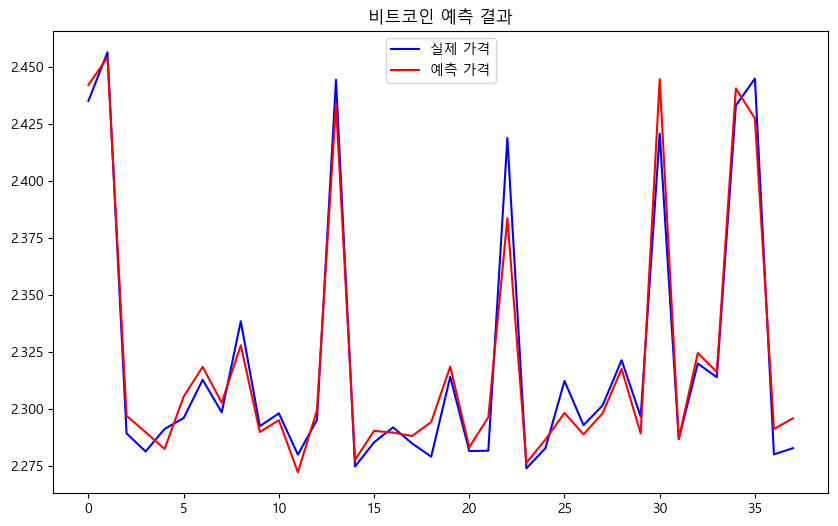

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='실제 가격', color='blue')
plt.plot(predictions, label='예측 가격', color='red')
plt.title("비트코인 예측 결과")
plt.legend()
plt.show()

In [23]:
# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = scaler.inverse_transform(predictions)
original_scale_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [24]:
# 결과 출력
print("샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")

샘플 예측값과 실제값:
예측값: 2.44, 실제값: 2.44
예측값: 2.45, 실제값: 2.46
예측값: 2.30, 실제값: 2.29
예측값: 2.29, 실제값: 2.28
예측값: 2.28, 실제값: 2.29


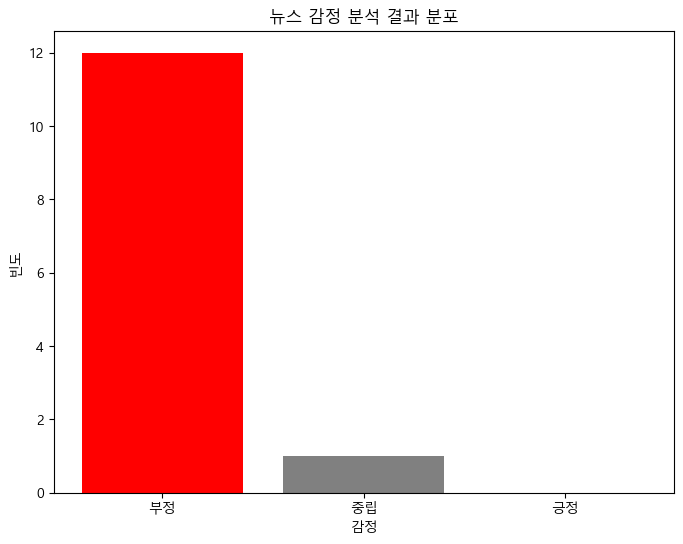

In [25]:
# 뉴스 감정 분석 결과 시각화
sentiment_counts = news_df['sentiment'].value_counts().sort_index()
categories = ['부정', '중립', '긍정']
counts = [
    sentiment_counts.get(1, 0) + sentiment_counts.get(2, 0),
    sentiment_counts.get(3, 0),
    sentiment_counts.get(4, 0) + sentiment_counts.get(5, 0)
]
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['red', 'gray', 'green'])
plt.title('뉴스 감정 분석 결과 분포')
plt.xlabel('감정')
plt.ylabel('빈도')
plt.show()

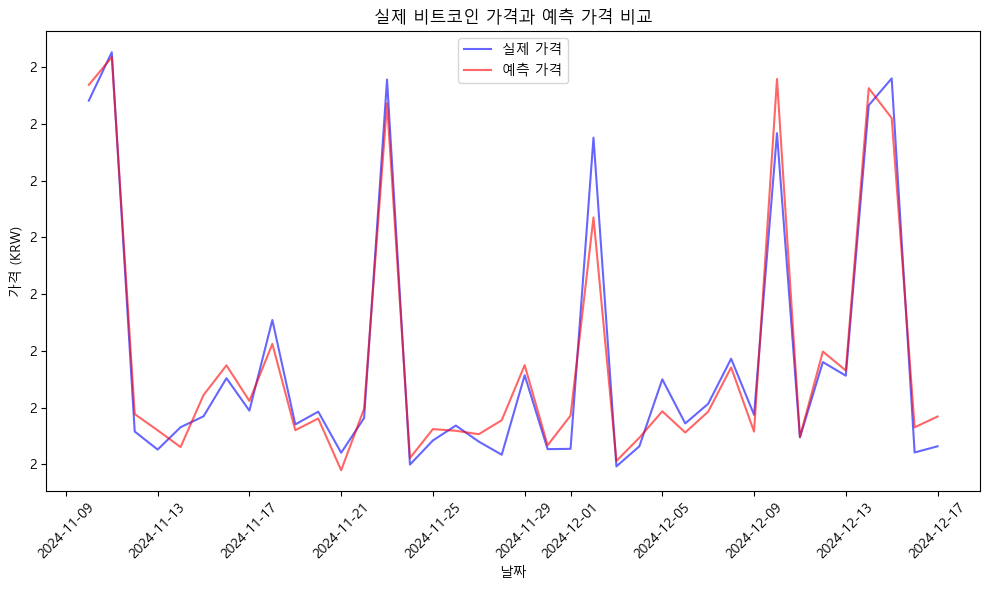

In [26]:
# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))
plt.plot(merged_df['date'][-len(original_scale_y_test):], original_scale_y_test, label='실제 가격', color='blue', alpha=0.6)
plt.plot(merged_df['date'][-len(original_scale_predictions):], original_scale_predictions, label='예측 가격', color='red', alpha=0.6)

# Y축 포맷 설정
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('실제 비트코인 가격과 예측 가격 비교')
plt.xlabel('날짜')
plt.ylabel('가격 (KRW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
results_df = pd.DataFrame({
    "Actual Price": original_scale_y_test.flatten(),
    "Predicted Price": original_scale_predictions.flatten()
})


In [28]:
# 2. 날짜별 비트코인 가격과 감정 점수 정리
merged_df_sorted = merged_df.sort_values("date")
price_and_sentiment_df = merged_df_sorted[["date", "price", "average_sentiment"]]

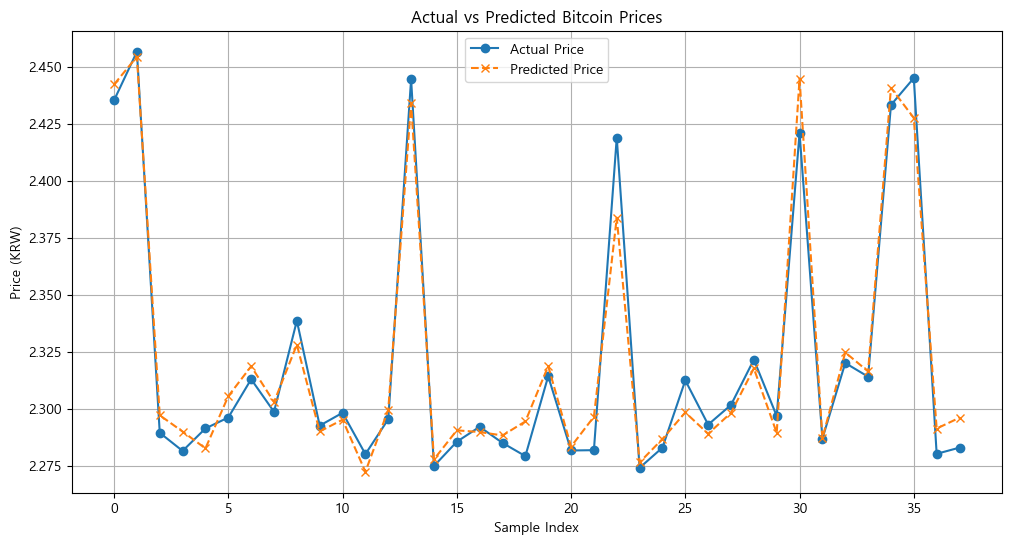

In [29]:

# 1. 예측 값과 실제 값 비교 그래프
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df["Actual Price"], label="Actual Price", linestyle="-", marker="o")
plt.plot(results_df.index, results_df["Predicted Price"], label="Predicted Price", linestyle="--", marker="x")
plt.title("Actual vs Predicted Bitcoin Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price (KRW)")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# 비트코인이 오를지 안 오를지 판단하는 함수 추가
def predict_bitcoin_trend(predictions, actual_values):
    """
    예측값과 실제값을 기반으로 비트코인의 상승 또는 하락 여부를 판단
    """
    if len(predictions) == 0 or len(actual_values) == 0:
        return "예측 데이터를 확인할 수 없습니다."

    latest_prediction = predictions[-1][0]  # 가장 최신 예측값
    latest_actual = actual_values[-1][0]    # 가장 최신 실제값

    if latest_prediction > latest_actual:
        return f"비트코인의 가격이 오를 것으로 예측됩니다. (예측값: {latest_prediction:,.2f} KRW)"
    elif latest_prediction < latest_actual:
        return f"비트코인의 가격이 내릴 것으로 예측됩니다. (예측값: {latest_prediction:,.2f} KRW)"
    else:
        return "비트코인의 가격이 변동이 없을 것으로 예측됩니다."

# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = scaler.inverse_transform(predictions)
original_scale_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 결과 출력
print("샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")

# 비트코인 상승/하락 여부 출력
trend_prediction = predict_bitcoin_trend(original_scale_predictions, original_scale_y_test)
print(trend_prediction)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
샘플 예측값과 실제값:
예측값: 2.44, 실제값: 2.44
예측값: 2.45, 실제값: 2.46
예측값: 2.30, 실제값: 2.29
예측값: 2.29, 실제값: 2.28
예측값: 2.28, 실제값: 2.29
비트코인의 가격이 오를 것으로 예측됩니다. (예측값: 2.30 KRW)


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 모델 정확도 지표 계산 함수
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = scaler.inverse_transform(predictions)
original_scale_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 정확도 지표 계산
rmse, mae, r2 = evaluate_model(original_scale_y_test, original_scale_predictions)

# 정확도 지표 출력
print("\n모델 정확도 지표:")
print(f"RMSE (Root Mean Squared Error): {rmse:,.2f}")
print(f"MAE (Mean Absolute Error): {mae:,.2f}")
print(f"R² (결정 계수): {r2:.4f}")

# 샘플 예측값과 실제값 출력
print("\n샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

모델 정확도 지표:
RMSE (Root Mean Squared Error): 0.01
MAE (Mean Absolute Error): 0.01
R² (결정 계수): 0.9672

샘플 예측값과 실제값:
예측값: 2.44, 실제값: 2.44
예측값: 2.45, 실제값: 2.46
예측값: 2.30, 실제값: 2.29
예측값: 2.29, 실제값: 2.28
예측값: 2.28, 실제값: 2.29
